# Landfast Ice Edge Detection

In [1]:
# import modules that we need
from pathlib import Path  # makes handling of paths and file names easier
import matplotlib.pyplot as plt
import xarray as xr       # convenient for reading NetCDF files and preserving metadata

import cartopy
import cartopy.crs as ccrs
import cmocean.cm as cmo
import cv2
import numpy as np

# input data directory
path = Path('/extra-space1/data/tikoralukupload/cis-weekly/nc/')

# region of interest
region = 'HB'

# Projection for mapping
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=150)

## Read Data
Here we use the [`xarray`](http://xarray.pydata.org/en/stable/) package that is very convienient to read NetCDF files because it preserves the data structure.

In [2]:
### Construct the full file name:
# Since path is a `pathlib.Path` object, we can create the full path of the input file by 
# appending the name with a forward slash "/". We also use the `.format()` method to use
# the variable `region` in the string of the file name.
fname = path / '{}.nc'.format(region)

### Load data into a `xarray.Dataset`:
# Note that the data is loaded lazily which means that no actual data are actually written
# into memory.
ds = xr.open_dataset(fname)

# Let's see what the data look like
print(ds)

<xarray.Dataset>
Dimensions:    (juld: 1043, x: 2654, y: 2595)
Coordinates:
  * x          (x) float64 3.45e+04 3.55e+04 3.65e+04 ... 2.686e+06 2.688e+06
  * y          (y) float64 3.76e+06 3.758e+06 3.758e+06 ... 1.166e+06 1.166e+06
  * juld       (juld) datetime64[ns] 1997-01-01 1997-02-01 ... 2020-10-26
Data variables:
    crs        int32 ...
    land       (y, x) float64 ...
    longitude  (y, x) float32 ...
    latitude   (y, x) float32 ...
    E_CA       (juld, y, x) float64 ...
    E_CB       (juld, y, x) float64 ...
    E_CC       (juld, y, x) float64 ...
    E_CD       (juld, y, x) float64 ...
    E_CT       (juld, y, x) float64 ...
    E_FA       (juld, y, x) float64 ...
    E_FB       (juld, y, x) float64 ...
    E_FC       (juld, y, x) float64 ...
    E_FD       (juld, y, x) float64 ...
    E_FE       (juld, y, x) float64 ...
    E_SA       (juld, y, x) float64 ...
    E_SB       (juld, y, x) float64 ...
    E_SC       (juld, y, x) float64 ...
    E_SD       (juld, y, x) f

As we can see, the dataset `ds` has three dimensions with coordinates `x`, `y`, and `juld`. Furthermore, the data variables contain information which coordinates their dimensions belong to.

### Subsetting
The dimensions and coordinates make it very easy to subset your data. There are two methods:

#### By Coordinate
Since the coordinates are retained for each variable we can use them to subset the dataset. In this case you would use the `.sel()` method. Let's assume you wanted to choose all data where `x` is between 1.0e6 and 1.5e6 m and `y` is less or equal 2.5e6 m, you would write
```
ds = ds.sel(x=slice(1.0e6, 1.5e6), y=slice(None, 2.5e6))
```

#### By Index
This method is similar to the conventional subsetting of `numpy` arrays, but makes use of the dimension names. To select your data based on the indexes, you should use the `.isel()` method. For example, we are now selecting all data where the index of the `x` dimension is greater that 1700 and the index of the `y` dimension is between 600 and 1450:

In [3]:
# subset `xarray.Dataset` by index
ds = ds.isel(x=slice(1700, None), y=slice(600, 1450))

# Note that this subsets the entire dataset and therefore, you only have to do it once for all variables.

To select one of the variables, you can either use the "dot notation", i.e., `ds.<name>` or treat `ds` like a `dict` and select the variables using brackets, i.e., `ds[<name>]`. Here, `<name>` is the name of the variable in the `xr.Dataset`.

In [5]:
# variable name
vname = 'N_CT'

# create shortcuts to the variables
lon = ds.longitude
lat = ds.latitude
# juld = ds.juld
land = ds.land
N_CT = ds[vname]

# Note that I chose the bracket notation for the last variable and used a variable `vname`
# to specify which field we want to look at. This makes the code more flexible as we could
# define a list of names that we can loop through to run the same analysis systematically
# for multiple variables.

# Let's have a look:
print(N_CT)

<xarray.DataArray 'N_CT' (juld: 1043, y: 850, x: 954)>
[845768700 values with dtype=float64]
Coordinates:
  * x        (x) float64 1.734e+06 1.736e+06 1.736e+06 ... 2.686e+06 2.688e+06
  * y        (y) float64 3.16e+06 3.158e+06 3.158e+06 ... 2.312e+06 2.31e+06
  * juld     (juld) datetime64[ns] 1997-01-01 1997-02-01 ... 2020-10-26
Attributes:
    units:         Original column value * 10
    grid_mapping:  crs


The variable `E_CT` is now a `xarray.DataArray`. Think of it as a `numpy` array, but the dimensions have the coordinates preserved. As you can see, it also has kept all the attributes from the original input file. Although the array has all the additional information it behaves like a `numpy` array. This just demonstrates the benefit of using the `xarray` package. The `.sel()` and `.isel()` methods that we applied to the whole `xarray.Dataset` above can also be applied to a `xarray.DataArray`.

If you are not convinced yet, here is a bonus: `xarray` comes with its own plotting routines (that use `matplotlib` under the hood)

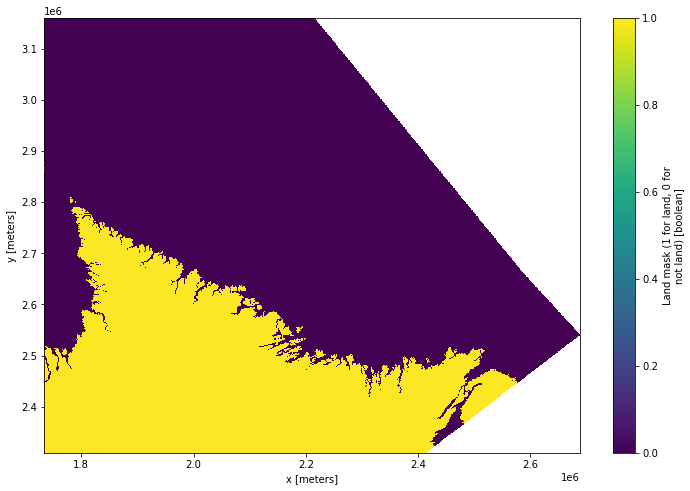

In [6]:
# plot the land/sea mask variable `land`
plt.figure(figsize=((12, 8)))
land.plot()

Since the variable `land` is has two dimensions, `xarray` automatically calls the `pcolormesh` function from the `matplotlib` package and and the embedded coordinate information (including the units) is used to specify the axes of the plot. Because of the stored attribute `long_name`, it also knows what data is actually stored in the variable. This information is used as a label for the colorbar.

We could have been more specific in the plotting command, but this is just is just a demonstration of the powerful features of `xarray` to make quick plots to check your data. 

## Coastline Detection

From the [OpenCV Documentation](https://docs.opencv.org/master/d4/d73/tutorial_py_contours_begin.html):

What are contours?

Contours can be explained simply as a curve joining all the continuous points (along the boundary), having same color or intensity. The contours are a useful tool for shape analysis and object detection and recognition.

* For better accuracy, use binary images. So before finding contours, apply threshold or canny edge detection.
* Since OpenCV 3.2, findContours() no longer modifies the source image.
* In OpenCV, finding contours is like finding white object from black background. So remember, object to be found should be white and background should be black.

[`threshold()`](https://docs.opencv.org/master/d7/d1b/group__imgproc__misc.html#gae8a4a146d1ca78c626a53577199e9c57)

Applies a fixed-level threshold to each array element.

The function applies fixed-level thresholding to a multiple-channel array. The function is typically used to get a bi-level (binary) image out of a grayscale image ( compare could be also used for this purpose) or for removing a noise, that is, filtering out pixels with too small or too large values. There are several types of thresholding supported by the function. They are determined by type parameter.

Parameters:
- `src`: input array (multiple-channel, 8-bit or 32-bit floating point).
- `thresh`:	threshold value.
- `maxval`:	maximum value to use with the `THRESH_BINARY` and `THRESH_BINARY_INV` thresholding types.
- `type`: thresholding type (see ThresholdTypes).

In [7]:
ret, thresh = cv2.threshold(land.values,       # src
                            0.5,               # thresh
                            1,                 # maxval
                            cv2.THRESH_BINARY) # type

[`findContours()`](https://docs.opencv.org/master/d3/dc0/group__imgproc__shape.html#gae4156f04053c44f886e387cff0ef6e08):

Finds contours in a binary image.

The function retrieves contours from the binary image using the algorithm [233](https://docs.opencv.org/master/d0/de3/citelist.html#CITEREF_Suzuki85). The contours are a useful tool for shape analysis and object detection and recognition.

Parameters:
- `image`:	Source, an 8-bit single-channel image. Non-zero pixels are treated as 1's. Zero pixels remain 0's, so the image is treated as binary . You can use compare, inRange, threshold , adaptiveThreshold, Canny, and others to create a binary image out of a grayscale or color one. If mode equals to `RETR_CCOMP` or `RETR_FLOODFILL`, the input can also be a 32-bit integer image of labels (CV_32SC1).
- `mode`: Contour retrieval mode, see RetrievalModes
- `method`:	Contour approximation method, see ContourApproximationModes
- `offset`:	Optional offset by which every contour point is shifted. This is useful if the contours are extracted from the image ROI and then they should be analyzed in the whole image context.

There are three arguments in `cv.findContours()` function, first one is source image, second is contour retrieval mode, third is contour approximation method. And it outputs the contours and hierarchy. Contours is a Python list of all the contours in the image. Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.

In [8]:
contours, hierarchy = cv2.findContours(thresh.astype(np.uint8), # image
                                       cv2.RETR_EXTERNAL,       # mode
                                       cv2.CHAIN_APPROX_NONE)   # method

print('I found {} contours'.format(len(contours)))

I found 20 contours


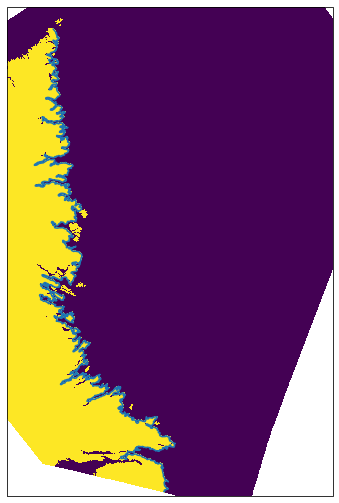

In [9]:
# pick the largest contour and assume it is surrounding the land
cland = np.squeeze(max(contours, key=cv2.contourArea))

# x- and y-indices of the land contour
xinds = xr.DataArray(cland[:,0], dims=['coastline'])
yinds = xr.DataArray(cland[:,1], dims=['coastline'])

# longitude and latitude of the land contour
lon_cland = lon.isel(x=xinds, y=yinds)
lat_cland = lat.isel(x=xinds, y=yinds)

# we manually find the minimum and maximum indexes of the coastline of interest
indmin = 2087
indmax = None

# get longitude and latitude of coastline of interest
lon_coast = lon_cland.isel(coastline=slice(indmin, indmax))
lat_coast = lat_cland.isel(coastline=slice(indmin, indmax))

# quick plot to check selected coastline
fig, ax = plt.subplots(1, 1, figsize=(7.5, 9), subplot_kw={'projection': rot})
ax.set_extent([-61.5, -56.5, 53.8, 61.5])
ax.pcolormesh(lon, lat, land, transform=ccrs.PlateCarree())
ax.plot(lon_coast, lat_coast, '-' ,transform=ccrs.PlateCarree(),zorder=4)

## Landfast Sea Ice "Sina"

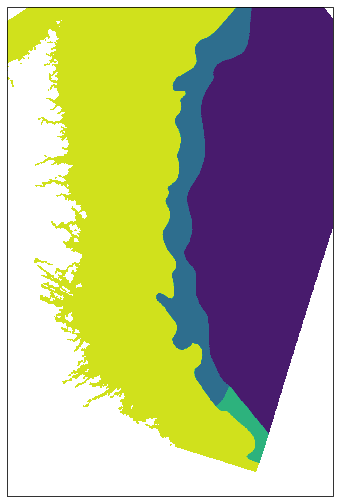

In [13]:
# select a day
CT = N_CT.sel(juld='1997-3-1')

# plot the data
fig, ax = plt.subplots(1, 1, figsize=(7.5, 9), subplot_kw={'projection': rot})
ax.set_extent([-61.5, -56.5, 53.8, 61.5])
ax.contourf(lon, lat, CT, transform=ccrs.PlateCarree())

Land and open water grid points are `NaN`. Landfast sea ice has CT = 11 by definition.

In [23]:
np.unique(CT)[:15]

array([  2.,  40.,  70.,  90.,  97., 100.,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan])

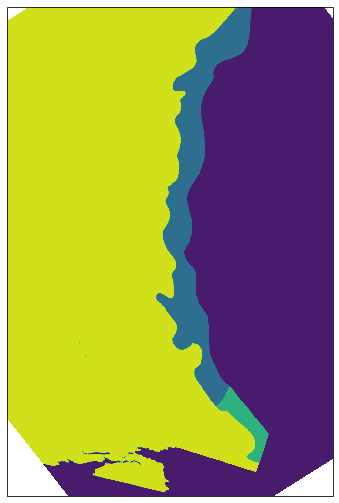

In [24]:
# - fill the NaN values with 11, i.e., pretend they are part of the landfast sea ice
# - select grid points that either have CT = 11 or are land as defined in the
#   land/sea mask `land`, i.e., not the open water area.
# - set all other values to zero
CT_sina = CT.fillna(100).where((CT==100) | (land==1), other=0)

# quick plot to check that we made the right selection
fig, ax = plt.subplots(1, 1, figsize=(7.5, 9), subplot_kw={'projection': rot})
ax.set_extent([-61.5, -56.5, 53.8, 61.5])
ax.contourf(lon, lat, CT_sina, transform=ccrs.PlateCarree())
ax.contourf(lon, lat, CT, transform=ccrs.PlateCarree())

The total area of landfast sea ice is 18381.0 km^2


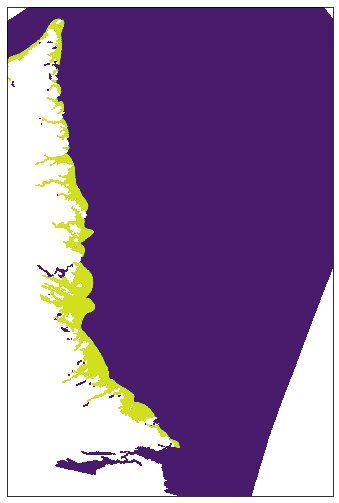

In [25]:
# create a binary image where all grid points that are not land or have CT = 11 are
# set to zero. (Technically, we could skip this step, because our input "image" is
# already binary.)
ret, thresh = cv2.threshold(CT_sina.values,    # src
                            97,                # thresh
                            100,                # maxval
                            cv2.THRESH_BINARY) # type\

# find the contours
contours, hierarchy = cv2.findContours(thresh.astype(np.uint8), # image
                                       cv2.RETR_EXTERNAL,       # mode
                                       cv2.CHAIN_APPROX_NONE)   # method

# Since the land grid points are part of this contour, we assume again that the
# contour of interest is the larges one.
tmp = np.squeeze(max(contours, key=cv2.contourArea))

# x- and y-indices of the land+sina contour
xinds = xr.DataArray(tmp[:,0], dims=['coastline'])
yinds = xr.DataArray(tmp[:,1], dims=['coastline'])

# longitude and latitude of the land+sina contour
lon_edge = lon.isel(x=xinds, y=yinds)
lat_edge = lat.isel(x=xinds, y=yinds)

# The exclusive interesection between the contour `tmp` and the land contour `cland`
# is the landfast sea ice "sina"

# Generate masks of both contours
msk_tmp = cv2.drawContours(np.zeros(CT.shape, np.uint8), [tmp], 0, 1, cv2.FILLED)
msk_cland = cv2.drawContours(np.zeros(CT.shape, np.uint8), [cland], 0, 1, cv2.FILLED)

# Now we find all the grid points that are contained in both masks
sina = cv2.bitwise_xor(msk_tmp, msk_cland)

# Create a xr.DataArray with the same dimensions and coordinates as the original data.
# We are also masking out the land and area where we didnt have any data.
sina = xr.DataArray(data=sina, dims=CT.dims, coords=CT.coords).where(land==0)

# In this array all grid points with landfast sea ice are equal to one. Since each grid
# cell represents an area of 1 km^2, we can get the total area of sina by computing
# the sum:
sina_area = sina.sum()

print('The total area of landfast sea ice is {} km^2'.format(sina_area.values))

# create plot
fig, ax = plt.subplots(1, 1, figsize=(7.5, 9), subplot_kw={'projection': rot})
ax.set_extent([-61.5, -56.5, 53.8, 61.5])
ax.contourf(lon, lat, sina, transform=ccrs.PlateCarree())

## Distance from Coast to Edge of Landfast Sea Ice

Now the we have identified both the coastline and the edge of the landfast sea ice, we can now calculate the distance between the two contours. The idea is to calculate the distance for each combination of the points along the coastline and along the ice edge. We then identify the minimum for each point along the coastline which can then be interpreted as the shortest distance between the land and open water.

Here we make use of the original Cartesian coordinate system of the data and the fact that respective x- and y-coordinates are saved in our `xarray.DataArray`. Additionally, we express the coordinates as complex numbers which allows us to compute the distances a little more elegantly.

[Text(0.5, 0, 'Coast Grid Points'),
 Text(0, 0.5, 'Ice Edge Grid Points'),
 Text(0.5, 1.0, 'Distance [km]')]

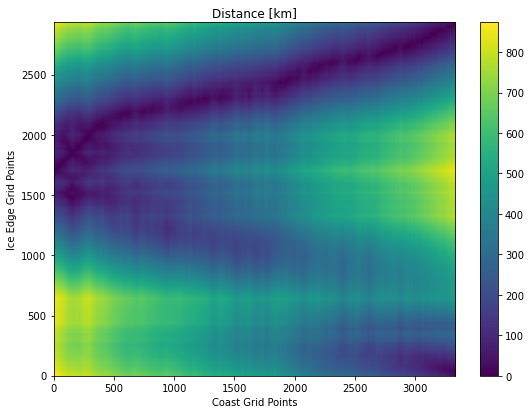

In [26]:
# x-and y coordinates of coastline and landfast ice edge as complex numbers
a = lon_coast.x + 1j * lon_coast.y 
b = lon_edge.x + 1j * lon_edge.y

# a is a "vector" of length N, where N is the number of grid points along the coast.
# b is a "vector" of length M, where M is the number of grid points along the ice edge.

# create a MxN matrix where each row is a copy of a
A = np.array([a,] * len(b))

# create a NxM matrix where each row is a copy of b
B = np.array([b,] * len(a)) # NxM matrix 

# Flatten the arrays which means that we append all rows an array  into one "vector".
# Note that we take the transpose of B before we flatten the array.
cst = A.flatten()
edge = B.T.flatten()

# Both "vectors" now have the same number (NxM) of elements that are all possible
# combinations of grid points along the coast and ice edge.

# Since the coordinates are complex numbers it is straightforward to calculate the distances
# between all grid points along the coast and along the ice edge. By reshaping the "vector"
# back into a MxN 
dst = np.abs(cst - edge).reshape((len(b), -1))

# Let's plot the array for illustration, convert distances to kilometer
fig, ax = plt.subplots(1, 1, figsize=(9, 6.5))
im = ax.imshow(dst / 1000., origin='lower')
plt.colorbar(im)
ax.set(xlabel='Coast Grid Points',
       ylabel='Ice Edge Grid Points',
       title='Distance [km]')

[Text(0.5, 0, 'Coast Grid Points'),
 Text(0, 0.5, 'Distance [km]'),
 Text(0.5, 1.0, 'Distance Between Coast and Landfast Ice Edge')]

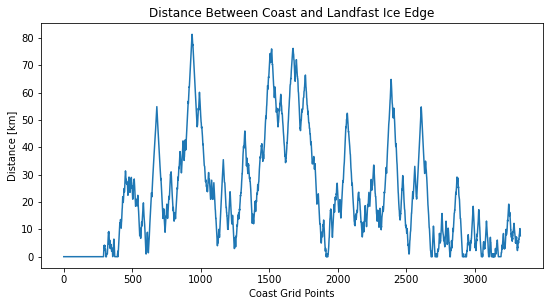

In [27]:
# the shortest distance between the coast and the edge of the landfast sea ice
# is the minimum along each column (axis=0).
edge_dist = np.min(dst, axis=0)

# plot the ice edge distance as a function of the coastline
fig, ax = plt.subplots(1, 1, figsize=(9, 4.5))
ax.plot(edge_dist / 1000.)
ax.set(xlabel='Coast Grid Points',
       ylabel='Distance [km]',
       title='Distance Between Coast and Landfast Ice Edge')

The figure above shows the variation in distance between land and the landfast ice edge. Note that this distance is agnostic to the orientation of the grid of the sea ice dataset. The spikes in the distance are probably associated with small bays along the coasline that are completely covered with sea ice.

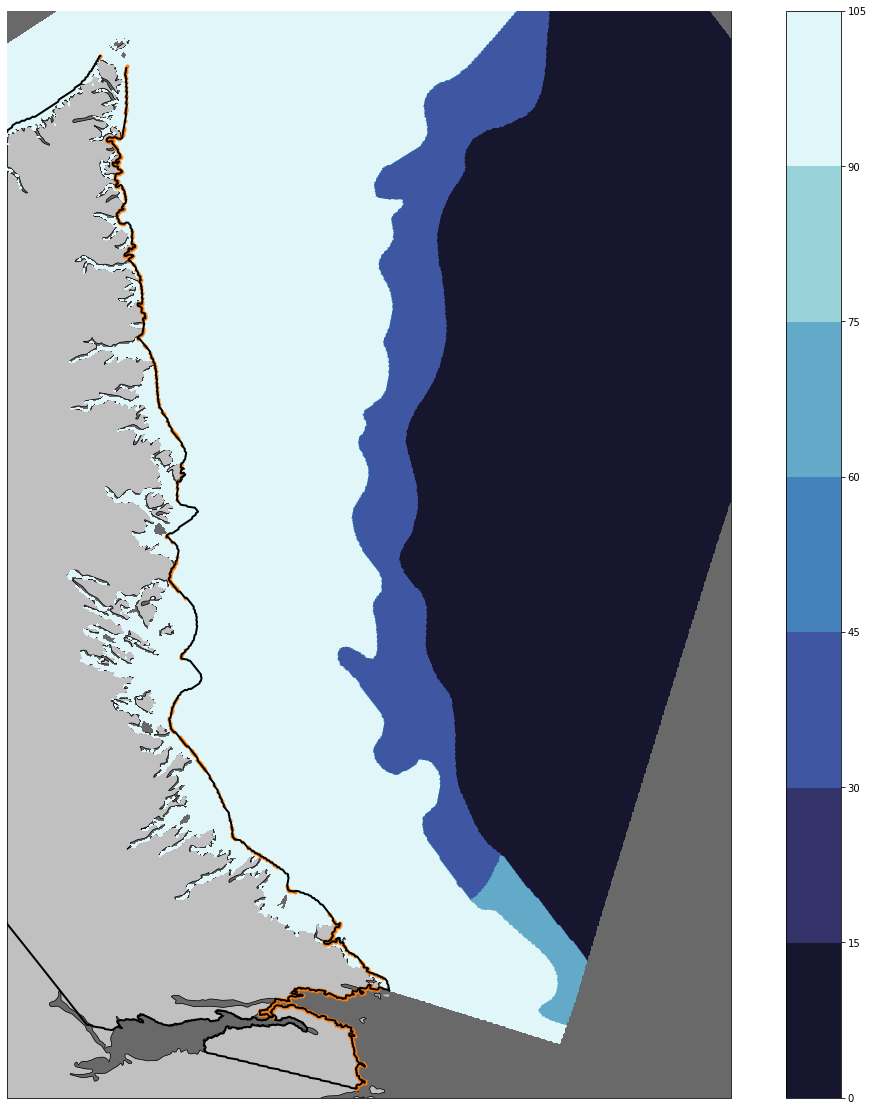

In [29]:
# find unique indices of grid points along the ice edge where the distance to land
# is shortest
edge_ind = np.unique(np.argmin(dst, axis=0))

# select the part of the ice edge that is between the first and last of those indices
lf_lon = lon_edge.isel(coastline=slice(edge_ind[0], edge_ind[-1]))
lf_lat = lat_edge.isel(coastline=slice(edge_ind[0], edge_ind[-1]))

# select only those points along the ice edge that are closest to land
shortest_lon = lon_edge.isel(coastline=edge_ind)
shortest_lat = lat_edge.isel(coastline=edge_ind)

# create plot
fig, ax = plt.subplots(1, 1, figsize=(20, 20), subplot_kw={'projection': rot})
ax.set_extent([-61.5, -56.5, 53.8, 61.5])

#Declare the land and ocean parameters
LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
edgecolor='black',
facecolor=('silver'),
linewidth=1)
OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
facecolor='dimgrey')

ax.add_feature(LAND_highres,zorder=2)
ax.add_feature(OCEAN_highres,zorder=3)
ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)

cs = ax.contourf(lon, lat, CT,
                 vmin=0,
                 vmax=100,
                 cmap=cmo.ice,
                 transform=ccrs.PlateCarree(),
                 zorder=4)
ax.plot(shortest_lon, shortest_lat,
        '.', color='C1',
        transform=ccrs.PlateCarree(),
        zorder=4)
ax.plot(lf_lon, lf_lat,
        color='k',
        linewidth=2,
        transform=ccrs.PlateCarree(),
        zorder=4)

plt.colorbar(cs, ax=ax)

The figure above shows the original data `CT` the black contour defines the edge of the landfast sea ice. The orange dots mark the points along the ice ege that are closest to land.